# MIE1624 - Introduction to Data Science & Analytics

# Group 19- Recommender Systems

## Importing & Installing Modules

In [2]:
# import required libraries
import numpy as np
import pandas as pd
#Importing cosine, Euclidean and Manhattan distances need to compute RMSE
from sklearn.metrics.pairwise import pairwise_distances
from heapq import nlargest
from sklearn.metrics import mean_squared_error
from math import sqrt
import os.path
import scipy.stats as st
import matplotlib.pyplot as plt
import warnings
from scipy.sparse.linalg import svds

In [3]:
warnings.filterwarnings('ignore') #ignore warnings

## Reading Data

From Recommender Lab, load movie rating data into notebook

In [4]:
# define constant for movie lens 100K directory
MOVIELENS_DIR = "ml-100k"
# use pre-defined test and train data from movie lens for cross validation
datasetsFileNames = [('u1.base', 'u1.test'),('u2.base', 'u2.test'),('u3.base', 'u3.test'),('u4.base', 'u4.test'),('u5.base', 'u5.test')]

In [44]:
# Load rating data from u.data file
fields = ['userID', 'itemID', 'rating', 'timestamp']
ratingDF = pd.read_csv('u.data', sep='\t', names=fields)

ratingDF.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [6]:
# Get number of users and movies
numUsers = len(ratingDF.userID.unique())
numItems = len(ratingDF.itemID.unique())

print("Number of users:", numUsers)
print("Number of items:", numItems)

Number of users: 943
Number of items: 1682


In [7]:
# Get movie information
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv('u.item', sep='|', names=fieldsMovies, encoding='latin-1')

moviesDF.head()

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,...,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Building User-Item Matrices

In [8]:
def matrix_builder(dataset, numUsers, numItems):
    matrix = np.zeros((numUsers, numItems), dtype=np.int8)
    #converts table data into matrix form
    for (index, userID, itemID, rating, timestamp) in dataset.itertuples():
        matrix[userID-1, itemID-1] = rating
    return matrix

Splitting test and training sets and appending to train and test matrices for each dataset.

In [9]:
trainUsrItmMatrixList = []
testUsrItmMatrixList = []

for trainFileName, testFileName in datasetsFileNames:
    trainDF = pd.read_csv(trainFileName, sep='\t', names=fields) #separates by tabs
    testDF = pd.read_csv(testFileName, sep='\t', names=fields)
    trainUsrItmMatrixList.append(matrix_builder(trainDF, numUsers, numItems))
    testUsrItmMatrixList.append(matrix_builder(testDF, numUsers, numItems))

## Data Exploration

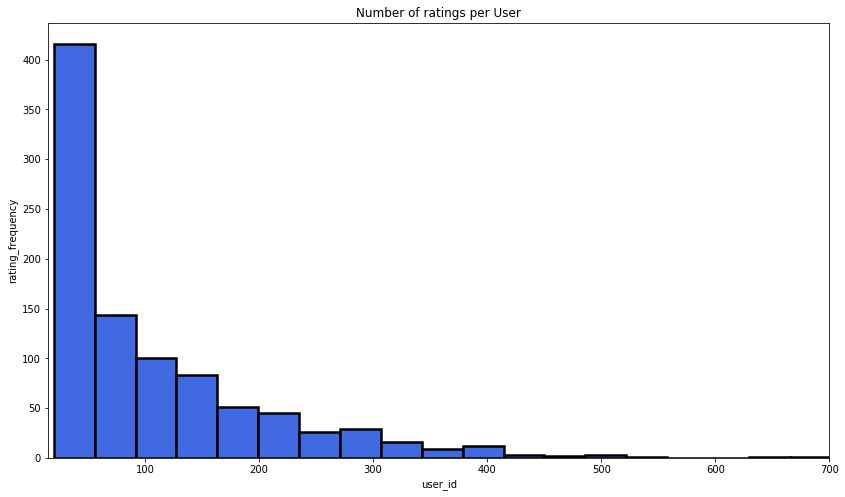

In [10]:
ratings_per_user= [np.size(userRatings.nonzero()) for userRatings in buildUserItemMatrix(ratingDF, numUsers, numItems)]

# Plot histogram
plt.figure(figsize=(14,8))
plt.hist(ratings_per_user, bins=20,color="royalblue",edgecolor = "black",linewidth = 2.5)
plt.title("Number of ratings per User")
plt.ylabel('rating_frequency')
plt.xlim((15,700))
plt.xlabel('user_id')
plt.show()

The findings indicate that the majority of users did not rate a significant number of movies.  This is crucial to know, since an unbalanced numbers of ratings per user could affect the recommender system. As such, we must normalize the trend of ratings in the table.   

## Creating Prediction Matrices

The prediction matrix computes for the unknown values by taking a weighted average and 

In [11]:
#Code borrowed from MIE1513 lab and modified for anlysis
def predictByRowSimilarity(trainSet, numRows, numCols, similarity, showProgress=False):
    # Initialize the predicted rating matrix with zeros
    predictionMatrix = np.zeros((numRows, numCols))
    
    for (row,item), rating in np.ndenumerate(trainSet):
        # Predict rating for every item that wasn't ranked by the user (rating == 0)
        if rating == 0:
            # Extract the users that provided rating for this item
            itemVector = trainSet[:,item]
            rowsRatings = itemVector[itemVector.nonzero()]
            
            # Get the similarity score for each of the users that provided rating for this item
            rowsSim = similarity[row,:][itemVector.nonzero()]
            
            # If there no users that ranked this item, use user's average
            if (len(rowsSim) == 0 or rowsSim.sum() == 0):
                rowVector = trainSet[row, :]
                ratedItems = rowVector[rowVector.nonzero()]
                
                # If the user didnt rated any item use 0, otherwise use average
                if len(ratedItems) == 0:
                    predictionMatrix[row,item] = 0
                else:
                    predictionMatrix[row,item] = ratedItems.mean()
            else:
                # predict score based on user-user similarity
                predictionMatrix[row,item] = (rowsRatings*rowsSim).sum() / rowsSim.sum()
    
    return predictionMatrix

## User-User Collaborative Filtering

For the first analysis, we will discuss user-user collaborative filtering.  Essentially, this approach allows us to compare users who have rated items similarly so that recommendations can be made to them.  

In [12]:
#Code borrowed from MIE1513 lab and modified for anlysis
def kFoldUserSimilarity(trainList, testList, simMetric):
    rmseList = [] 

    # Predict each training set
    for i, (train, test) in enumerate(zip(trainList, testList)):
        
        # Evaluate similarity matrix
        rowSimilarity = []
        
        # Evaluate similarity matrix
        rowSimilarity = []
        if (simMetric == 'cosine'):
            rowSimilarity = 1 - pairwise_distances(train, metric='cosine')
        else:
            rowSimilarity = 1/pairwise_distances(train, metric=simMetric)
                
        userSimPrediction = predictByRowSimilarity(train, len(train), numItems, rowSimilarity)
        
        predItems = userSimPrediction[test.nonzero()].flatten() 
        testItems = test[test.nonzero()].flatten()
        
        rmseList.append(sqrt(mean_squared_error(predItems, testItems)))
        
    return rmseList

### Hyperparameter Tuning

Calculating different metrics for each user database.  Each hyperparameter will calculate the cosine similarities, euclidian and manhatten distances.  

###### Cosine Similarities

In [13]:
rmse_cos = kFoldUserSimilarity(trainUsrItmMatrixList, testUsrItmMatrixList,'cosine')

In [14]:
print(f"List of RMSE accuracies across each dataset: {rmse_cos}")
print(f"Average RMSE across all cross-validation folds: {sum(rmse_cos)/len(rmse_cos)}")

List of RMSE accuracies across each dataset: [1.026449013124381, 1.0214387664779507, 1.0132940326457187, 1.0094003999022945, 1.0161883961525586]
Average RMSE across all cross-validation folds: 1.0173541216605808


###### Euclidean Distances

In [15]:
rmse_euc = kFoldUserSimilarity(trainUsrItmMatrixList, testUsrItmMatrixList,'euclidean')

In [16]:
print(f"List of RMSE accuracies across each dataset: {rmse_euc}")
print(f"Average RMSE across all cross-validation folds: {sum(rmse_euc)/len(rmse_euc)}")

List of RMSE accuracies across each dataset: [1.0320116953852745, 1.0272927052903946, 1.0177291897968457, 1.0146756260430294, 1.0207202508681685]
Average RMSE across all cross-validation folds: 1.0224858934767425


###### Manhattan Distances

In [17]:
rmse_man = kFoldUserSimilarity(trainUsrItmMatrixList, testUsrItmMatrixList,'manhattan')

In [18]:
print(f"List of RMSE accuracies across each dataset: {rmse_man}")
print(f"Average RMSE across all cross-validation folds: {sum(rmse_man)/len(rmse_man)}")

List of RMSE accuracies across each dataset: [1.032136277590931, 1.0270378009760248, 1.017195834625724, 1.0147650754579611, 1.020861626536442]
Average RMSE across all cross-validation folds: 1.0223993230374169


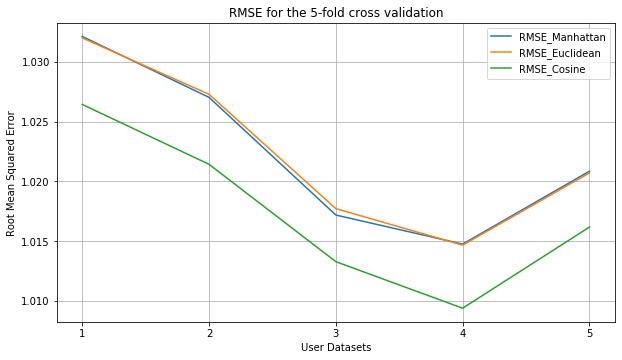

In [19]:
plt.figure(figsize=(10,5.5))
plt.plot(range(1,6),rmse_man)
plt.plot(range(1,6),rmse_euc)
plt.plot(range(1,6),rmse_cos)
plt.legend(["RMSE_Manhattan","RMSE_Euclidean","RMSE_Cosine"])

plt.xticks(range(1,6,1))
plt.ylabel("Root Mean Squared Error")
plt.title("RMSE for the 5-fold cross validation")
plt.xlabel("User Datasets")
plt.grid()
plt.show()

The cosine similarity metric works better than the euclidian metric.  This is because euclidian is not normalizing the vectors to account for strength preference (i.e. two users mave have similar tastes, but one may tend to have inflated ratings). The manhattan metric performs worse than euclidian as it is also a distance metric, but uses strictly horizontal or vertical paths instead of the direct path between the two vectors.

# Item-Item Collaborative Filtering

For the second analysis, we will discuss item-item collaborative filtering.  This approach is similar to that of user-user CF, except now it focuses on directly comparing the item column vectors. 

In [20]:
#Code borrowed from MIE1513 lab and modified for anlysis
def predictByItemSimilarity(trainSet, numUsers, numItems, similarity):
    return predictByRowSimilarity(trainSet, numItems, numUsers, similarity)

def kFoldItemSimilarity(trainList, testList,simMetric):
    rmseList = []
    bestPred = []
    trainIndex = 0
    
    for i, (train, test) in enumerate(zip(trainList, testList)):
        users = len(train)
        # Transpose user-item matrix
        trainTrans = np.transpose(train)
        
        # Evaluate similarity matrix
        sim = []
        if (simMetric == 'cosine'):
            sim = 1 - pairwise_distances(trainTrans, metric='cosine')
        else:
            sim = 1/pairwise_distances(trainTrans, metric=simMetric)
        
        # Perform similarity analysis where Items are now rows
        userSimPrediction = np.transpose(predictByItemSimilarity(trainTrans, users, numItems, sim))
        
        # Keep best prediction matrix based on RMSE
        predItems = userSimPrediction[test.nonzero()].flatten() 
        testItems = test[test.nonzero()].flatten()
    
        err= sqrt(mean_squared_error(predItems, testItems))
        
        if (len(rmseList) == 0 or err < min(rmseList)):
            bestPred = userSimPrediction
            trainIndex = i
        
        # Evaluate performance metrics RMSE, P@K and R@K
        rmseList.append(err)
        
    return rmseList, bestPred, trainIndex

### Hyperparameter Tuning

Hyperparameter tuning for item-item CF.  Calculates cosine similarity, Euclidean and Manhattan distances.

###### Cosine Similarities

In [21]:
i_rmse_cos, itemSimPred, bestItemTrainIndex = kFoldItemSimilarity(trainUsrItmMatrixList, testUsrItmMatrixList,'cosine')

In [22]:
print(f"List of RMSE accuracies across each dataset: {i_rmse_cos}")
print(f"Average RMSE across all cross-validation folds: {sum(i_rmse_cos)/len(i_rmse_cos)}")

List of RMSE accuracies across each dataset: [1.0377631264364244, 1.0207280585350078, 1.0101820660011795, 1.0136832839209695, 1.0180579656376574]
Average RMSE across all cross-validation folds: 1.0200829001062477


###### Euclidean Distance

In [23]:
i_rmse_euc, itemSimPred2, bestItemTrainIndex2 = kFoldItemSimilarity(trainUsrItmMatrixList, testUsrItmMatrixList,'euclidean')

In [24]:
print(f"List of RMSE accuracies across each dataset: {i_rmse_euc}")
print(f"Average RMSE across all cross-validation folds: {sum(i_rmse_euc)/len(i_rmse_euc)}")

List of RMSE accuracies across each dataset: [1.044696886389039, 1.0310581293416694, 1.0199663134939265, 1.0210606537801088, 1.0234599533723185]
Average RMSE across all cross-validation folds: 1.0280483872754125


###### Manhattan Distance

In [25]:
i_rmse_man, itemSimPred3, bestItemTrainIndex3 = kFoldItemSimilarity(trainUsrItmMatrixList, testUsrItmMatrixList,'manhattan')

In [26]:
print(f"List of RMSE accuracies across each dataset: {i_rmse_man}")
print(f"Average RMSE across all cross-validation folds: {sum(i_rmse_man)/len(i_rmse_man)}")

List of RMSE accuracies across each dataset: [1.0391181664437406, 1.026793260793566, 1.0167699190364432, 1.0161181641069457, 1.0182866848846701]
Average RMSE across all cross-validation folds: 1.0234172390530731


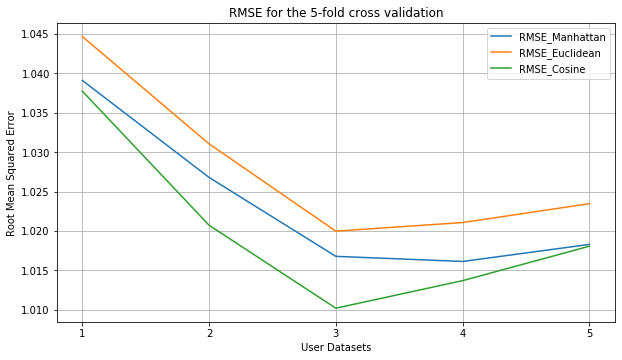

In [27]:
plt.figure(figsize=(10,5.5))
plt.plot(range(1,6),i_rmse_man)
plt.plot(range(1,6),i_rmse_euc)
plt.plot(range(1,6),i_rmse_cos)
plt.legend(["RMSE_Manhattan","RMSE_Euclidean","RMSE_Cosine"])

plt.xticks(range(1,6,1))
plt.ylabel("Root Mean Squared Error")
plt.title("RMSE for the 5-fold cross validation")
plt.xlabel("User Datasets")
plt.grid()
plt.show()

Similarly to user-user, the cosine similarity metric performed the best of the 3.  

### User-User VS Item-Item Comparison

It was found in both evaluations that using cosine similarity was the best metric compared to those of Euclidean and Manhattan.  When comparing the cosine similarities between U-U and I-I (1.017 and 1.02, respectively), it was found that U-U had the better RMSE.  This ultimately makes sense, because the number of ratings per user is greater than the number of ratings per item.

## Movie Recommendations

In [28]:
# Get movie list titles based on IDs
def getMovieList(moviesDataset, idList):
    names = list(map(lambda x: moviesDataset[moviesDataset.movieID == x]["movieTitle"].values[0], idList))
    return names

# Find top k similar movies based on a simularity matrix
def kSimilarMovies(movieDataset, movieSim, movieID, k):
    print("Top {0} movies for movie: {1}".format(k, getMovieList(movieDataset,[movieID])[0]))
    return getMovieList(movieDataset, [x+1 for x in np.argsort(movieSim[movieID-1])[0:k]])

# Merge train and predictions to get more information for similarity comparison
def mergePredictAndTrain(train, prediction):
    # Initialize the merged rating matrix with zeros
    mergeMatrix = np.zeros((numUsers, numItems))
    
    # Merge the two matricies together
    for (row,item), rating in np.ndenumerate(train):
        if rating == 0:
            mergeMatrix[row,item] = prediction[row,item]
        else:
            mergeMatrix[row,item] = train[row,item]
    return mergeMatrix

In [29]:
def getMovieIDs(moviesDataset, query):
    resultDF = pd.DataFrame(moviesDataset["movieTitle"].str.contains(query))
    movieIDs = [index+1 for index, value in resultDF.itertuples() if (value)]
    return [[movieID, movieTitle] for movieID, movieTitle in zip(movieIDs, getMovieList(moviesDF, movieIDs))]

In [30]:
# Create Item Similarity Matrix with merged train and prediction matrix
movieSim = 1 - pairwise_distances(np.transpose(mergePredictAndTrain(trainUsrItmMatrixList[bestItemTrainIndex], itemSimPred)), metric='cosine')

###### Retrieve Top 8 Movies by Title

In [47]:
# Search for top 8 recommended movies by Title
enter_movie = input("Enter movie title here: ")

extract_id = str(getMovieIDs(moviesDF, enter_movie))
mov_id = int(str(extract_id.split(",")[0]).split("[")[2])
print(f"Movie ID: {mov_id}\n")

movieID = mov_id

kSimilarMovies(moviesDF, movieSim, movieID, 8)

Enter movie title here: Forrest Gump
Movie ID: 69

Top 8 movies for movie: Forrest Gump (1994)


['Symphonie pastorale, La (1946)',
 'Target (1995)',
 'Favor, The (1994)',
 'The Courtyard (1995)',
 'Chairman of the Board (1998)',
 'Gate of Heavenly Peace, The (1995)',
 'Entertaining Angels: The Dorothy Day Story (1996)',
 'Shopping (1994)']

## SVD using Surprise Package (Sci-kit learn)

The famous SVD algorithm, as popularized by Simon Funk during the Netflix Prize. 
Link to learn more: https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD

In [36]:
#Import necessary Surprise libraries
#Note: you will need to download the library by entering the following in your conda script: $ conda install -c conda-forge scikit-surprise
#$ pip install scikit-surprise did not work (it took too long)

from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

# Load the movielens-100k dataset.
data = Dataset.load_builtin('ml-100k')

# Use the famous SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and save results
svd_results= cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9457  0.9392  0.9345  0.9243  0.9360  0.9359  0.0070  
Fit time          6.35    5.87    6.09    5.87    5.84    6.01    0.19    
Test time         0.32    0.16    0.16    0.20    0.16    0.20    0.06    


Average RMSE across all cross-validation folds: 0.9359394393476048


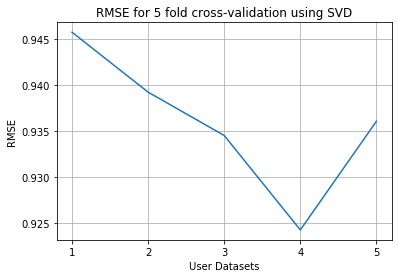

In [37]:
#Printing the average cross-fold accuracy and plotting the RMSE curve for SVD

print("Average RMSE across all cross-validation folds:", svd_results["test_rmse"].mean())

plt.plot(range(1,6),svd_results["test_rmse"])
plt.title("RMSE for 5 fold cross-validation using SVD")
plt.ylabel("RMSE")
plt.xlabel("User Datasets")
plt.xticks(range(1,6,1))
plt.grid()
plt.show()